# ConnectX with AI
Competition: www.kaggle.com/c/connectx<br>
Useful link: https://www.kaggle.com/learn/intro-to-game-ai-and-reinforcement-learning

In [1]:
%%capture
!pip install nbclient --upgrade
!pip install kaggle-environments

!pip install 'tensorflow==1.15.0'
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"

import warnings
warnings.filterwarnings('ignore')

## Environment and Utils

In [2]:
import kaggle_environments as kg
env = kg.make('connectx', debug = True)

Loading environment football failed: No module named 'gfootball'


In [3]:
def play_match(agent, opponent, env = env, show_replay = True, play_first = True):
    env.reset() 
    agents = [agent, opponent] if play_first else [opponent, agent]
    names =  [agent.__name__, opponent] if play_first else [opponent, agent.__name__]
    print('1st player (Ks) =', names[0])
    print('2nd player (Ds) =', names[1])
    env.run(agents)
    if show_replay:
        env.render(mode = 'ipython', width = 500, height = 450)

In [4]:
import numpy as np

def get_win_percentages(agent1, agent2, n_rounds = 100):
    config = {'rows': 6, 'columns': 7, 'inarow': 4}    
    names =  [agent1.__name__, agent2]
    outcomes = kg.evaluate('connectx', [agent1, agent2], config, [], n_rounds // 2)   
    outcomes += [[b, a] for [a, b] in kg.evaluate('connectx', [agent2, agent1], config, [], n_rounds-n_rounds // 2)]
    print(f'{names[0]} win percentage:', np.round(outcomes.count([1,-1]) / len(outcomes), 2))
    print(f'{names[1]} Win Percentage:', np.round(outcomes.count([-1,1]) / len(outcomes), 2))
    print(f'Invalid plays by {names[0]}:', outcomes.count([None, 0]))
    print(f'Invalid plays by {names[1]}:', outcomes.count([0, None]))

## Agent Modeling

### Smart Agent
This agent plays according to the following strategy;
- if there's a move that wins, play it;
- if there's a move that lets the opponent win the next turn, play it;
- otherwise, play a random non-full column.



In [5]:
# Selects middle column
def agent_smart(obs, config):

    # ------------------------------------- #

    import numpy as np

    def board2grid(board, config):
        return np.asarray(board).reshape(config.rows, config.columns)

    # def play(grid, col, piece, config):
    #     next_grid = grid.copy()
    #     for row in range(config.rows - 1, -1, -1):
    #         if next_grid[row][col] == 0:
    #             break
    #     next_grid[row][col] = piece
    #     return next_grid

    def is_winning_move(col, piece, obs, config):
        grid = board2grid(obs.board, config)

        # compute this column height
        row = config.rows - 1
        while row >= 0 and grid[row][col] != 0:
            row -= 1
        if row < 0: return False

        # vertical alignment
        if row <= config.rows - config.inarow:
            cnt = 1
            while grid[row + cnt][col] == piece:
                cnt += 1
                if cnt >= config.inarow:
                    return True

        # horizontal and diagonal alignment
        for dy in [-1, 0, 1]:
            cnt = 0
            for dx in [-1, 1]:
                x = col + dx
                y = row + dx * dy
                while (y >= 0 and y < config.rows 
                    and  x >= 0 and x < config.columns
                    and grid[y][x] == piece):
                    x += dx
                    y += dx * dy
                    cnt += 1
                    if cnt >= (config.inarow - 1): 
                        return True
        return False

    def get_player_and_opponent(obs):
        player = obs.mark
        opponent = (player % 2) + 1
        return player, opponent

    # ------------------------------------- #

    player, opp = get_player_and_opponent(obs)

    for c in range(config.columns):
        if obs.board[c] == 0 and is_winning_move(c, player, obs, config):
            print(obs.step + 1, '-', f'{c} for the win')
            return c

    for c in range(config.columns):
        if obs.board[c] == 0 and is_winning_move(c, opp, obs, config):
            print(obs.step + 1, '-', f'{c} for the block')
            return c
        
    import random
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    return random.choice(valid_moves)

### Smart Agent 2
For each board position, this agent calculates through an heuristic the reward of playing a given column. It then chooses randomly amongst the best columns.<br>
The heuristic searches for 5 specific disk patterns inside the board, and counts the occurrences of each one of them. The total reward is then calculated as a weighted sum of the occurrences.

In [6]:
# Selects middle column
def agent_smart2(obs, config):

    # ------------------------------------- #

    import numpy as np
    import random

    def score_move(grid, col, mark, config):
        next_grid = drop_piece(grid, col, mark, config)
        return get_heuristic(next_grid, mark, config)

    def drop_piece(grid, col, mark, config):
        next_grid = grid.copy()
        for row in range(config.rows - 1, -1, -1):
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = mark
        return next_grid

    def get_heuristic(grid, mark, config):
        A = 1e8
        B = 1e4
        C = 1e2
        D = -1
        E = -1e6
        num_twos = count_windows(grid, 2, mark, config)
        num_threes = count_windows(grid, 3, mark, config)
        num_fours = count_windows(grid, 4, mark, config)
        num_twos_opp = count_windows(grid, 2, mark % 2 + 1, config)
        num_threes_opp = count_windows(grid, 3, mark % 2 + 1, config)
        score = (A * num_fours + B * num_threes + C * num_twos 
                 + D * num_twos_opp + E * num_threes_opp)
        return score

    def check_window(window, num_discs, piece, config):
        return (window.count(piece) == num_discs and
                window.count(0) == config.inarow - num_discs)
        
    def count_windows(grid, num_discs, piece, config):
        num_windows = 0
        # horizontal
        for row in range(config.rows):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(grid[row, col:col + config.inarow])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # vertical
        for row in range(config.rows - (config.inarow - 1)):
            for col in range(config.columns):
                window = list(grid[row:row+config.inarow, col])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # positive diagonal
        for row in range(config.rows - (config.inarow - 1)):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(grid[range(row, row + config.inarow), range(col, col + config.inarow)])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # negative diagonal
        for row in range(config.inarow-1, config.rows):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(grid[range(row, row - config.inarow, -1), range(col, col + config.inarow)])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        return num_windows

    # ------------------------------------- #

    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)

    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config) for col in valid_moves]))

    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]

    return random.choice(max_cols)

In [7]:
# play_match(agent_smart, agent_smart2, play_first = True)
# get_win_percentages(agent_smart2, agent_smart, n_rounds = 100)

### Deep Reinforcement Learning Agent
The idea is to use a NN that, given a board, outputs a probability for each column to play. The agent then pickes a column in accordance to this distribution. <br>
To train the NN, a policy is required that rewards the agent accordingly to its move. The better the move, the higher the reward. At the end of the game, a total reward is given to the agent (cumulative reward).


In [2]:
import tensorflow as tf
from kaggle_environments import make, evaluate
from gym import spaces
import numpy as np

class Connect4Gym:
    def __init__(self, opponent = 'random'):
        ks_env = make('connectx', debug = True)
        self.env = ks_env.train([None, opponent])
        self.rows = ks_env.configuration.rows
        self.cols = ks_env.configuration.columns
        self.reward_range = (-10, 1)
        self.action_space = spaces.Discrete(self.cols)
        self.observation_space = spaces.Box(low = 0, high = 2 ,dtype = np.int,
                                            shape = (self.rows, self.cols, 1))
        self.spec, self.metadata = None, None
    
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs.board).reshape(self.rows, self.cols, 1)

    def change_reward(self, old_reward, done):
        if old_reward == 1: return 1
        elif done: return -1
        else: return 1 / (self.rows * self.cols)
    
    def step(self, action):
        action = int(action)
        is_valid = (self.obs.board[action] == 0)
        if is_valid: 
            self.obs, old_reward, done, _ = self.env.step(action)
            reward = self.change_reward(old_reward, done)
        else:
            reward, done, _ = -10, True, {}
        return np.array(self.obs.board).reshape(self.rows, self.cols, 1), reward, done, _

Loading environment football failed: No module named 'gfootball'


In [3]:
import os
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv

env = Connect4Gym(opponent = "random")

log_dir = 'ppo/'
os.makedirs(log_dir, exist_ok = True)

monitor_env = Monitor(env, log_dir, allow_early_resets = True)
vec_env = DummyVecEnv([lambda: monitor_env])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
from stable_baselines import PPO1 
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters = 32, filter_size = 3, stride = 1, 
                         init_scale = np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters = 64, filter_size = 3, stride = 1, 
                         init_scale = np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden = 512, init_scale = np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor = modified_cnn)
        
# Initialize agent
model = PPO1(CustomCnnPolicy, vec_env, verbose = 0)















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
# Train agent
model.learn(total_timesteps = 100000)



NameError: ignored

NameError: ignored

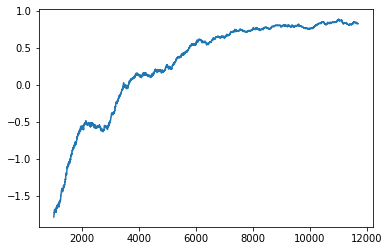

In [6]:
# Plot cumulative reward
import pandas as pd
import 
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col = None)['r']

df.rolling(window = 1000).mean().plot()
plt.show()

## Submission

In [8]:
import inspect
import os
import sys

def write_agent_to_file(function, file):
    with open(file, 'w') as f:
        f.write(inspect.getsource(function))
        print(function, 'written to', file)

# write agent to file
write_agent_to_file(agent_smart2, 'submission.py')

# load agent from file
out = sys.stdout
submission = kg.utils.read_file('submission.py')
agent = kg.agent.get_last_callable(submission)
sys.stdout = out

# try play the agent
env = kg.make('connectx', debug = True)
env.run([agent, agent])
print(env)
print('Success!' if env.state[0].status == env.state[1].status == 'DONE' else 'Failed...')

<function agent_smart2 at 0x7f558b715048> written to submission.py
Success!
